# Embed, Encode and Predict

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [35]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "r")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))
print(word2id)

vocab_size: 6498
{'brucet': 6291, 'detroit': 1960, 'henize': 617, 'hulman': 2516, 'stoppered': 3170, 'catfish': 2206, 'calves': 2585, 'bowmanj': 194, 'duos': 3225, 'stockton': 2736, 'ak': 2865, 'boi': 1463, 'warming': 2514, 'irs': 109, 'chaps': 5477, 'estrogen': 6271, '0x0': 4345, 'vivaldi': 838, 'fig': 63, 'literal': 5075, 'adult': 6438, 'ast': 3568, 'phrasing': 1641, 'slaughtering': 3501, 'problematic': 2108, 'bmd': 4174, 'chlorine': 357, 'resumed': 1168, 'pierce': 4288, 'fluent': 4061, 'ig': 3987, '27th': 3317, 'squalor': 242, 'drafted': 1053, 'promising': 1558, 'dismantling': 403, 'charge': 2268, 'landreneau': 5827, 'eng': 4553, 'reduce': 5501, 'cze': 5163, 'dissolved': 4893, 'pep': 4315, 'karr': 3589, 'analog': 427, 'community': 3013, 'key': 1212, 'welcomed': 57, 'painted': 5078, 'agriculture': 3107, 'wintrumpet': 5680, 'grenade': 1944, 'boosters': 1612, 'oryx': 5671, 'arriving': 2768, 'halici': 1097, 'completly': 148, 'calderon': 1801, 'condensers': 2613, 'reproductive': 4738, '0

## Load GloVe Embeddings

In [63]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
  try:
    cols = line.decode('utf-8').strip().split(" ")
    #print('???',cols[0])
    word = cols[0]
    #print(word2id)
    if not word in word2id:
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    
    E[idx] = vec
    #print(idx, ' | ', vec)
  except Exception as e:
    print('gg',e)
print('??????????')
fglove.close()
print(E.shape)

??????????
(6498, 300)


## Compute Document Vectors

In [64]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [65]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [66]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [67]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [68]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

__Note:__ 

Setting the embedding weights and making the layer trainable (so backprop can update the weights) results in much better performance (0.788 accuracy on test set, 0.9831 on training set) than making the layer non-trainable (0.706 accuracy on test set, 0.7827 on training set). One possible reason is that making the embedding layer non-trainable drops the number of trainable parameters from 12,540,970 to 321,970 (about 10x our base embed-predict BoW model with 32,120 parameters).

In [69]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")
sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     weights=[E])(sent_inputs)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE))(sent_emb)

sent_encoder = Model(inputs=sent_inputs, outputs=sent_enc)
sent_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 300)           1949400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240600    
Total params: 2,190,000
Trainable params: 2,190,000
Non-trainable params: 0
_________________________________________________________________


In [70]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")
doc_emb = TimeDistributed(sent_encoder)(doc_inputs)
doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE))(doc_emb)

fc1_dropout = Dropout(0.2)(doc_enc)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 60)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 200)           2190000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               75300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
Total para

In [71]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10
11872/11872 [==============================] - 41s 3ms/step - loss: 3.0055 - acc: 0.0511 - val_loss: 2.9947 - val_acc: 0.0447
Epoch 2/10
11872/11872 [==============================] - 37s 3ms/step - loss: 2.9932 - acc: 0.0526 - val_loss: 2.9945 - val_acc: 0.0447
Epoch 3/10
11872/11872 [==============================] - 37s 3ms/step - loss: 2.9916 - acc: 0.0555 - val_loss: 2.9946 - val_acc: 0.0447
Epoch 4/10
11872/11872 [==============================] - 37s 3ms/step - loss: 2.9910 - acc: 0.0540 - val_loss: 2.9948 - val_acc: 0.0447
Epoch 5/10
10176/11872 [========================>.....] - ETA: 5s - loss: 2.9907 - acc: 0.0563

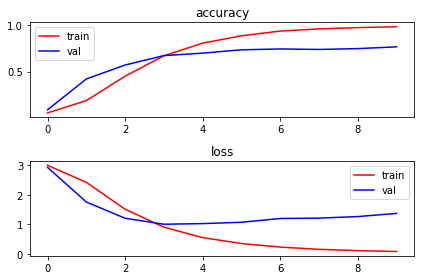

In [14]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [ ]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))